### Simulating a Maintenance Contract

- Notebook content :
- Load the libraries
- Loading the Data
- Transforming the column `order_purchase_timestamp` to the number of days since the last purchase
- Function to get the data for modelization
- Calculate the ARI score over time
- Define time intervals
- Calculate the ARI score for each time interval and visualize the results

#### Goal
To ensure that the clustering model remains stable and accurate over time by monitoring its performance and retraining it as needed. This involves:

1. **Finalizing an Optimized Clustering**: Ensure the clustering model is well-tuned and makes sense from a business perspective.
2. **Simulating Stability Over Time**: Track how stable the clusters are over different time periods.

#### Recommendations
1. **Use ARI (Adjusted Rand Index)**: Measure how similar the clusters are over time to decide when to retrain the model.
2. **Monitor Feature Distribution**: Analyze changes in the distribution of your features over time using graphical methods or statistical tests like the Kolmogorov-Smirnov test.

#### Vigilance Points
- Ensure consistency between the data used for initial training and the data for future predictions.


Date range: 2016-09-04 21:15:19 to 2018-10-17 17:30:18
days_since_last_purchase statistics:
count    96096.000000
mean       289.061928
std        153.646258
min          0.000000
25%        165.000000
50%        270.000000
75%        399.000000
max        772.000000
Name: days_since_last_purchase, dtype: float64
Scores for interval 3 days:
 []
Scores for interval 7 days:
 []
Scores for interval 15 days:
 []
Scores for interval 30 days:
 [0.3908607992493531, 0.35143071925362757, 0.4413551321617124, 0.3747740871203489, 0.24748497076636009, 0.3314314267233097, 0.25909978598080324, 0.3417538034149818, 0.23601340154602385, 0.24248791004388384, 0.3030339988933144, 0.3118026540459949, 0.21948934870109682, 0.21338438935943121, 0.23676423994208456, 0.28773727025414025, 0.25980315952710864, 0.25678029859060564, 0.23561442560572796, 0.14747800605391362, 0.0976869973096123, 0.03113145567457397, 0.0]
Scores for interval 60 days:
 [0.14663548944903612, 0.04177015834547368, 0.1255964401591444, 0.064

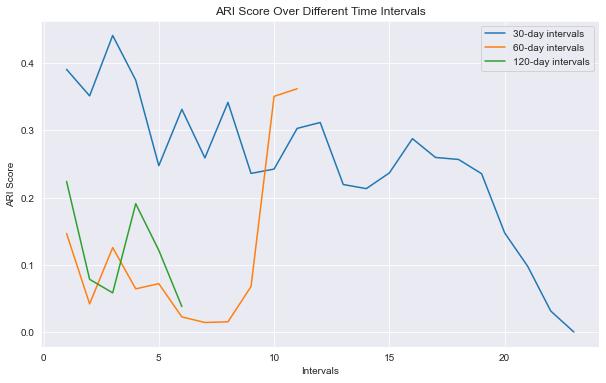

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
from datetime import datetime

# Set environment variable to suppress the KMeans memory leak warning on Windows
os.environ["OMP_NUM_THREADS"] = "1"

# Load the data
db_path = os.path.join('..', 'data')
df_final_kmeans_path = os.path.join(db_path, 'df_final_kmeans_with_clusters.csv')
df_final_kmeans = pd.read_csv(df_final_kmeans_path)

# Define the date format
date_format = '%Y-%m-%d %H:%M:%S'  # Adjust this format according to your date format which is 'YYYY-MM-DD HH:MM:SS' in this case

# Identify the available date ranges
min_date_str = df_final_kmeans['order_purchase_timestamp'].min() # Minimum date in the dataset as a string format for comparison
max_date_str = df_final_kmeans['order_purchase_timestamp'].max() # Maximum date in the dataset as a string format for comparison
min_date = datetime.strptime(min_date_str, date_format) # Convert the minimum date to a datetime object, e.g. from '2016-09-04 21:15:19' to 2016-09-04 21:15:19
max_date = datetime.strptime(max_date_str, date_format) # Convert the maximum date to a datetime object, e.g. from '2018-09-03 09:06:57' to 2018-09-03 09:06:57

# Print the Date range which is: 2016-09-04 21:15:19 to 2018-10-17 17:30:18
print(f"Date range: {min_date_str} to {max_date_str}")

# Transform the 'order_purchase_timestamp' column to the number of days since the max date in the dataset
df_final_kmeans['days_since_last_purchase'] = df_final_kmeans['order_purchase_timestamp'].apply(lambda x: (max_date - datetime.strptime(x, date_format)).days)

# Display unique values of 'days_since_last_purchase'
print("days_since_last_purchase statistics:")
print(df_final_kmeans['days_since_last_purchase'].describe())

# Function to get the data for modeling
def get_data_for_model(data, start_time, interval):
    end_time = start_time + interval
    return data[(data['days_since_last_purchase'] >= start_time) & (data['days_since_last_purchase'] < end_time)]

# Define specific intervals
frequencies = [3, 7, 15, 30, 60, 120]  # 3, 7, 15, 30, 60, 120 days
scores_dict = {}

# Select only numeric columns for scaling and clustering
numeric_columns = df_final_kmeans.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns.remove('days_since_last_purchase')

# Initial model on the data of D_0
initial_time = df_final_kmeans['days_since_last_purchase'].min()

for interval in frequencies:
    scores = []
    D0 = get_data_for_model(df_final_kmeans, initial_time, interval)

    if not D0.empty and len(D0) >= 4:  # Ensure at least 4 samples
        scaler = RobustScaler()
        D0_scaled = scaler.fit_transform(D0[numeric_columns])
        model_0 = KMeans(n_clusters=4).fit(D0_scaled)  # Use 4 clusters

        # Temporal loop to track the stability of the model
        for t in range(int(initial_time) + interval, int(df_final_kmeans['days_since_last_purchase'].max()), interval):
            Di = get_data_for_model(df_final_kmeans, t, interval)
            if Di.empty or len(Di) < 4:  # Ensure at least 4 samples
                continue

            Di_scaled = scaler.transform(Di[numeric_columns])
            model_i = KMeans(n_clusters=4).fit(Di_scaled)  # Use 4 clusters

            # Calculate the ARI
            labels_0 = model_0.predict(Di_scaled)
            labels_i = model_i.predict(Di_scaled)
            score = adjusted_rand_score(labels_0, labels_i)
            scores.append(score)
    
    scores_dict[interval] = scores

# Print ARI scores for each interval
for interval, scores in scores_dict.items():
    print(f"Scores for interval {interval} days:\n", scores)

# Visualize the results
plt.figure(figsize=(10, 6))
for interval, scores in scores_dict.items():
    if scores:
        print(f"Plotting scores for interval {interval} days: {scores}")  # Print scores for verification
        plt.plot(range(1, len(scores) + 1), scores, label=f'{interval}-day intervals')
plt.xlabel('Intervals')
plt.ylabel('ARI Score')
plt.title('ARI Score Over Different Time Intervals')
plt.legend()
plt.show()


### Summary of ARI Scores and Stability

- **3-Day Intervals**: It was not possible to calculate the ARI score for 3-day intervals due to the lack of sufficient samples.
- **7-Day Intervals**: It was not possible to calculate the ARI score for 7-day intervals due to the lack of sufficient samples.
- **15-Day Intervals**: It was not possible to calculate the ARI score for 15-day intervals due to the lack of sufficient samples.
- **30-Day Interval**:
  - ARI scores start relatively high but show a decreasing trend with some fluctuations.
  - Scores range from approximately 0.44 to 0.0, indicating that while there is some stability initially, the clusters become less consistent over time.
- **60-Day Interval**:
  - ARI scores are generally positive and exhibit some stability, though there are noticeable fluctuations.
  - Scores range from approximately 0.35 to 0.01, showing that clusters are moderately consistent over two-month periods, but there is some instability.
- **120-Day Interval**:
  - ARI scores for this interval fluctuate as well, but the overall trend suggests moderate stability over longer periods.
  - Scores range from approximately 0.22 to 0.03, indicating that while the clusters remain somewhat consistent, there is variability.

#### Graph Interpretation

- The graph illustrates the differences in cluster stability across the three time intervals (30, 60, and 120 days).
- **30-Day Interval**: The ARI scores decline more sharply, suggesting that cluster consistency decreases over shorter periods.
- **60-Day Interval**: The ARI scores exhibit more fluctuations but are more consistently positive, indicating that clusters are relatively stable over two months.
- **120-Day Interval**: The ARI scores show some variability, indicating that while clusters can be stable over a four-month period, there is still room for improvement in long-term consistency.

### Conclusion and Recommendations

1. **Cluster Stability**:
   - The ARI scores suggest that clusters tend to be less stable over shorter periods (30 days), with declining consistency. 
   - Clusters over 60 and 120-day intervals show moderate stability, though fluctuations indicate that the model may need periodic re-evaluation.

2. **Model Maintenance**:
   - To ensure the stability of the clustering model, it is recommended to re-evaluate and recalibrate the clusters every two to four months, depending on the business need for stability versus sensitivity to change.
   - Frequent re-evaluations (every 30 days) may lead to unnecessary adjustments and instability, which might not be desirable for long-term business planning.

3. **Continuous Monitoring**:
   - Regularly monitor ARI scores at each 60-day and 120-day interval to maintain cluster stability.
   - If significant drops in ARI scores are observed, especially over the longer 120-day interval, a full re-evaluation and adjustment of clusters may be necessary.

### Example Maintenance Plan

- **Bi-Monthly Re-evaluation**: Re-evaluate clusters every two months to check stability using the 60-day interval.
- **Stability Reports**: Produce cluster stability reports at each re-evaluation to document performance and necessary adjustments.
- **Adjustment Based on ARI Scores**: If ARI scores for the 120-day interval fall significantly, conduct a full re-evaluation and adjust clusters accordingly.

### Final Conclusion

Given the analysis, re-evaluating and recalibrating clusters every **three months** is recommended, balancing stability and avoiding unnecessary adjustments, as it falls within the suggested two to four-month range.